### This notebook:
    - Reads the spot-leverl barcode calling results of all the methods reported in table 3 
    - Convert them to cell-level barcode calls 
    - Generates Table 3 results

In [1]:
cd ..

/home/jupyter-mhaghigh@broadinst-ee45a/workspace_DL/2023_Haghighi_IJCAI


In [28]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pdb
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from barcodefit.dataobjects import spot_utils
from skimage.util import img_as_uint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

################################## Read Data Objects
batch='20210124_6W_CP228'
plate='B';well='Well4';
# batch_abbrv=batch.split('_')[-1]
# dataset_dir='/storage/data/marziehhaghighi/pooledCP/'
# rootDir='/storage/data/marziehhaghighi/pooledCP/'


d_inf=[batch,plate,well]
dfInfo,dfInfo_comp, dataset_train, dataset_val,barcode_ref_array = spot_utils.read_metadata(d_inf,'train');
total_sites_n=len(dataset_train)

############# Read NGS data
ngs_csv_file = './resource/CP228_NGS_Reads_And_Library_Mapped.csv'
ngs_counts = spot_utils.read_ngs_counts_4target_well(ngs_csv_file,well)

metadata_dir='./resource/'
barcode_ref_list,codebook,barcode_ref_array = spot_utils.read_barcode_list(metadata_dir)
    
########### False additions to the reflib
false_additions=['TTTTGTTTT','ACTTTTTTT','GCGCCCCCC','AAACAAAAA','CTTCTCTCT','CCCGTCCCC','AACGAAAAA','CTTTTCTTT','AAGAAAAGA']
# rand_ls=['TTTTGTTTT','ACTTTTTTT','GCGCCCCCC','AAACAAAAA','CTTCTCTCT','CCCGTCCCC','AACGAAAAA','CTTTTCTTT','AAGAAAAGA']

In [5]:
ds_site=dataset_train[2]
img_site=ds_site.image_info[0]['site']
orig_im_w=5500;

dataset_dir='/dgx1nas1/cellpainting-datasets/2018_11_20_Periscope_Calico/'

############ Read overlay
batch_abbrv=batch.split('_')[-1]
overlay_dir = dataset_dir+"workspace/analysis/"+batch+"/"+batch_abbrv+plate+"-"+well+"-"+\
    str(img_site)+"/CorrDNA_Site_"+str(img_site)+"_Overlay.png"
ov_im = spot_utils.read_resize_overlay_pooled(overlay_dir,orig_im_w)

############ Read Nuclei.csv
nucl_csv = pd.read_csv(dataset_dir+"workspace/analysis/"+batch+"/"+batch_abbrv+plate+"-"+well+"-"+\
    str(img_site)+"/Nuclei.csv")
nucl_csv=nucl_csv.rename(columns={"ObjectNumber":"Parent_Cells",\
  'Location_Center_X':'Nuclei_Location_Center_X','Location_Center_Y':'Nuclei_Location_Center_Y'})\
    [["Parent_Cells","Nuclei_Location_Center_X","Nuclei_Location_Center_Y"]].astype(int)

########### masked overlays by object number
colored_cells = spot_utils.colormask_cells_to_parent_cell_number(img_as_uint(ov_im), nucl_csv)    


/home/jupyter-mhaghigh@broadinst-ee45a/.conda/envs/bspl/lib/python3.9/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


(65535, 65535, 65535)


### Read results generated by each baseline method

In [8]:
results_path='./results/benchmark_results/'

starfish_params={'filename':'starfish_B_Well4_60.csv',\
                 'barcode_col':'target',\
                 'confidence_col':'distance',\
                 'confidence_is_distance':True
                }

postcode_params={'filename':"postcode_B_Well4_60.csv",\
                 'barcode_col':'Code',\
                 'confidence_col':'Probability',\
                 'confidence_is_distance':False
                }
 
bardensr_params={'filename':"bardensr_B_Well4_60.csv",\
             'barcode_col':'barcode_bases',\
             'confidence_col':None,\
             'confidence_is_distance':False             
                }

istdeco_params={'filename':'istdeco_B_Well4_60.csv',\
             'barcode_col':'target_name',\
             'confidence_col':'quality',\
             'confidence_is_distance':False              
                }

plepi_params={'filename':'PLePI-ISS_B_Well4_60.csv',\
             'barcode_col':'Barcodes_called_dl',\
             'confidence_col':'Barcodes_called_prodP',\
             'confidence_is_distance':False              
                }


ds_info_dict={'starfish':starfish_params,\
              'postcode':postcode_params,\
              'bardensr':bardensr_params,\
              'istdeco':istdeco_params,\
              'PLePI':plepi_params}


In [36]:
img_site, len(barcode_ref_list),len(false_additions),len(set(barcode_ref_list+false_additions))

(60, 184, 9, 193)

### Single Site NGS scores and visualization

nan count (3329, 24)
starfish 0.92 6000
FDR 0.0 0.1278 (26055, 24) FDR_cell_level 0.0 0.0883
nan count (42, 9)
postcode 0.88 5930
FDR 0.0001 0.0695 (29036, 9) FDR_cell_level 0.0 0.0799
nan count (0, 9)
bardensr 0.95 5967
FDR 0.0103 0.0 (20052, 9) FDR_cell_level 0.003 0.0
nan count (0, 9)
istdeco 0.73 3804
FDR 0.0077 0.0 (12474, 9) FDR_cell_level 0.006 0.0
nan count (0, 46)
PLePI 0.94 6050
FDR 0.0 0.0918 (85872, 46) FDR_cell_level 0.0 0.0819


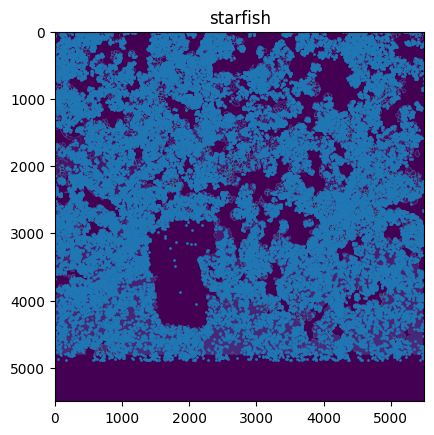

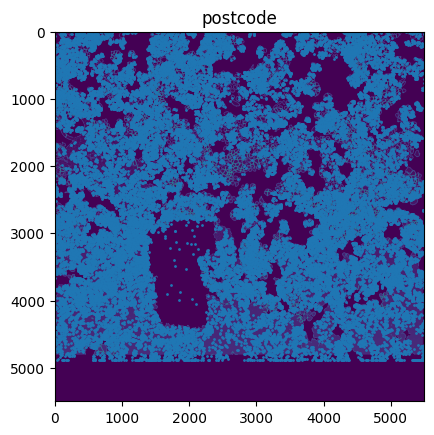

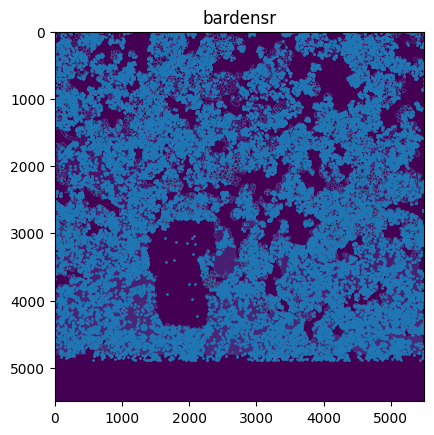

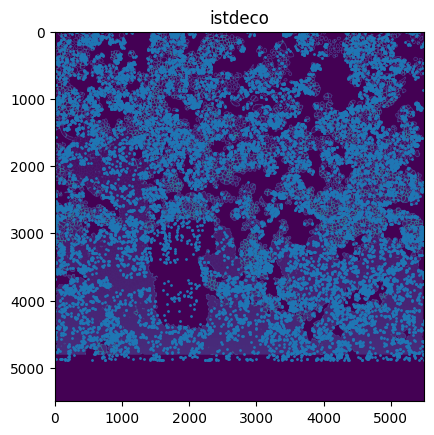

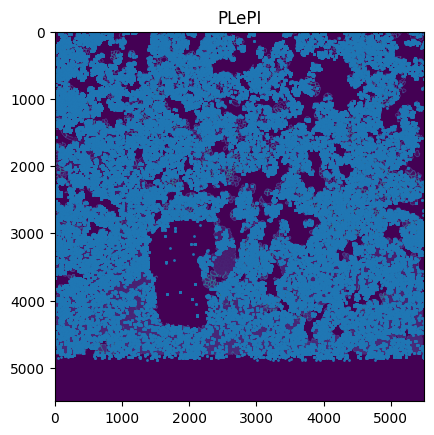

In [33]:
res_table_indices = ds_info_dict.keys()
res_table_indices = ['istdeco','postcode','starfish','bardensr','PLePI'] # manually entering to keep the order of table 3 of the paper
results_table = pd.DataFrame(index=res_table_indices,columns=['ngs_match','cell recovery',\
                                                              'targeted_c','targeted_b',\
                                                              'trick_c','trick_b',\
                                                              'not-in-cb_c','not-in-cb_b',\
                                                              'uncalled_c'])

n_cells=nucl_csv.shape[0]

for ds in ds_info_dict.keys():
    
    params=ds_info_dict[ds]
    results = pd.read_csv(results_path+params['filename'])

    bb_ys=results['y'].astype(int).values
    bb_xs=results['x'].astype(int).values

    if 1:
        plt.figure();plt.title(ds)
        plt.imshow(colored_cells)
        plt.scatter(bb_xs,bb_ys,s=1)
        

    results['Parent_Cells']=colored_cells[bb_ys,bb_xs]            
    results['Metadata_Site']=img_site

    
    
    results=results[results['Parent_Cells']!=0].reset_index(drop=True)
    print('nan count',results[results[params['barcode_col']].isnull()].shape)
    if ds in ['bardensr']:
        results=results[~results[params['barcode_col']].isnull()].reset_index(drop=True)

    targeted_b=results[results[params['barcode_col']].isin(barcode_ref_list)].shape[0]/results.shape[0]
    FDR1=results[results[params['barcode_col']].isin(false_additions)].shape[0]/results.shape[0]
    FDR2=results[~results[params['barcode_col']].isin(barcode_ref_list+false_additions)].shape[0]/results.shape[0]
    

    if params['confidence_col']:    
        cells_called_perSite=results.sort_values([params['confidence_col']],ascending=params['confidence_is_distance']).\
        groupby(['Metadata_Site','Parent_Cells']).head(1).reset_index().sort_values(by=['Metadata_Site','Parent_Cells'])
            
    else:
        cells_called_perSite=results.groupby(['Parent_Cells',params['barcode_col']]).size().\
        reset_index().sort_values(by=0).groupby(['Parent_Cells']).tail(1).reset_index(drop=True)
        
        
    cells_called_perSite=cells_called_perSite[cells_called_perSite['Parent_Cells']!=65535]
    
    FDR1_cellcalls=cells_called_perSite[cells_called_perSite[params['barcode_col']].\
                                        isin(false_additions)].shape[0]/cells_called_perSite.shape[0]#n_cells
    FDR2_cellcalls=cells_called_perSite[~cells_called_perSite[params['barcode_col']].\
                                        isin(barcode_ref_list+false_additions)].shape[0]/cells_called_perSite.shape[0]#n_cells     
    
    uncalled_c =(n_cells-cells_called_perSite.shape[0])/n_cells
    
    cells_called_perSite_targetted=cells_called_perSite[cells_called_perSite[params['barcode_col']].isin(barcode_ref_list)].reset_index(drop=True)
    cell_recovery=cells_called_perSite_targetted.shape[0]/n_cells
    targeted_c=cells_called_perSite_targetted.shape[0]/cells_called_perSite.shape[0]
    ################################## 
    baseline_counts=(cells_called_perSite_targetted.groupby([params['barcode_col']]).size()/cells_called_perSite_targetted.shape[0]).reset_index()
    merged_ngs_bs=ngs_counts.merge(baseline_counts, left_on='prefix9', right_on=params['barcode_col']).rename(columns={0:'Fracs'})
    NGS_match=np.round(merged_ngs_bs['Fracs'].corr(merged_ngs_bs['Fraction_of_Reads']),2)
    print(ds, NGS_match,cells_called_perSite_targetted.shape[0])
    print('FDR',np.round(FDR1,4),np.round(FDR2,4),results.shape,'FDR_cell_level',np.round(FDR1_cellcalls,4),np.round(FDR2_cellcalls,4))
#     'targeted_b', 'trick_b', 'not-in-cb_b', 'targeted_c', 'trick_c','not-in-cb_c'
    results_table.loc[ds,:]=NGS_match,np.round(cell_recovery,2),\
    np.round(targeted_c,3),np.round(targeted_b,3),\
    np.round(FDR1_cellcalls,4), np.round(FDR1,4),\
    np.round(FDR2_cellcalls,4), np.round(FDR2,4),\
    uncalled_c


In [26]:
Table3= results_table[['ngs_match','cell recovery','targeted_c','targeted_b','trick_c',\
               'trick_b','not-in-cb_c','not-in-cb_b']]
Table3

,ngs_match,cell recovery,targeted_c,targeted_b,trick_c,trick_b,not-in-cb_c,not-in-cb_b
istdeco,0.73,0.45,0.994,0.992,0.006,0.0077,0.0,0.0
postcode,0.88,0.71,0.92,0.93,0.0,0.0001,0.0799,0.0695
starfish,0.92,0.72,0.912,0.872,0.0,0.0,0.0883,0.1278
bardensr,0.95,0.71,0.997,0.99,0.003,0.0103,0.0,0.0
PLePI,0.94,0.72,0.918,0.908,0.0,0.0,0.0819,0.0918


In [34]:
print(Table3.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} & ngs\_match & cell recovery & targeted\_c & targeted\_b & trick\_c & trick\_b & not-in-cb\_c & not-in-cb\_b \\
\midrule
istdeco  &      0.73 &          0.45 &      0.994 &      0.992 &   0.006 &  0.0077 &         0.0 &         0.0 \\
postcode &      0.88 &          0.71 &       0.92 &       0.93 &     0.0 &  0.0001 &      0.0799 &      0.0695 \\
starfish &      0.92 &          0.72 &      0.912 &      0.872 &     0.0 &     0.0 &      0.0883 &      0.1278 \\
bardensr &      0.95 &          0.71 &      0.997 &       0.99 &   0.003 &  0.0103 &         0.0 &         0.0 \\
PLePI    &      0.94 &          0.72 &      0.918 &      0.908 &     0.0 &     0.0 &      0.0819 &      0.0918 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_51044/2324512218.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Table3.to_latex())
